# CSC-based super-resolution demo

In [36]:
import numpy as np
import scipy.io as sio


import F2O.F2O_utils as F2O
import F2O.constants as f2oDef
from F2O.imgUtils.image_utils import ImgMetrics, ImgPlot, ImgRead

from F2O.fwOp.fwOperator import fwOp_f

from F2O.noise.noiseModels import noiseModels

from F2O.PG_freq import apg as fAPG


import multiprocessing
import pyfftw

pyfftw.config.NUM_THREADS = multiprocessing.cpu_count()
pyfftw.config.PLANNER_EFFORT = 'FFTW_MEASURE'


# If you get an error while loading the F2O, then
# 
# * Exit Jupyter
# * Go to the F2O root dir, and execute
#      export PYTHONPATH=$PYTHONPATH:`pwd`
# * Relaunch Jupyter
#

## Read list of images, select noise model 

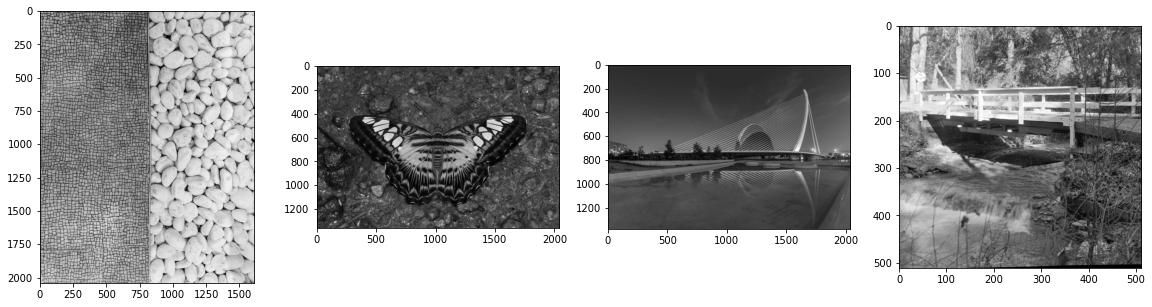

In [2]:

import requests
from io import BytesIO

# Test images from the SIPI image database
fname = {0: requests.get('http://sipi.usc.edu/database/misc/5.2.10.tiff'),   # bridge (grayscale)
         1: requests.get('http://sipi.usc.edu/database/misc/boat.512.tiff'), # boat (grayscale)
         2: requests.get('http://sipi.usc.edu/database/misc/4.2.03.tiff'),   # mandrill (color)
        }


testImgs = ImgRead(enableJAX=False)

# Read HD images
testImgs.list.append(['/home/jaru/docs/papers/rls-cv/data/DIV2K_train_HR/0005.png','g'])
testImgs.list.append(['/home/jaru/docs/papers/rls-cv/data/DIV2K_train_HR/0183.png','g'])
testImgs.list.append(['/home/jaru/docs/papers/rls-cv/data/DIV2K_train_HR/0677.png','g'])

# include a 'small' image for quick test purposes
testImgs.list.append([BytesIO(fname.get(0).content),'g'])


uHRes = testImgs.readListImgs()              # read list of images, normalize them between 0 and 1
                                             # uHRes   : original high-resolution images
    
pltImg  = ImgPlot()
pltImg.plotNImgs(uHRes, len(uHRes), None, 5)    ## Read list of images, select noise model 



## Downsample test images / select input

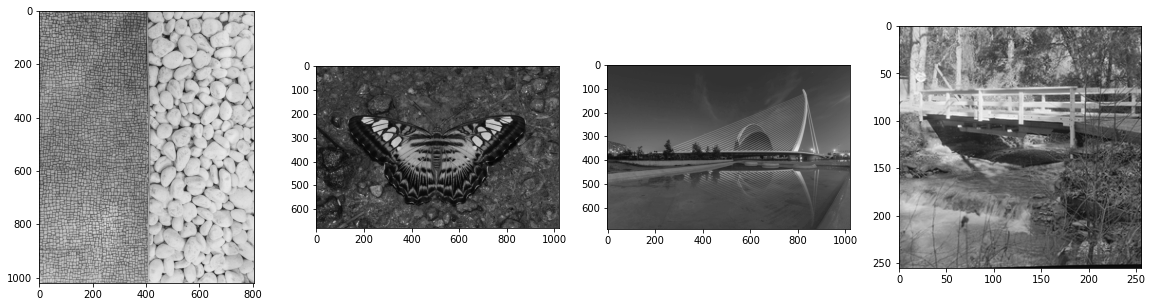

In [12]:
import PIL as PIL
from PIL import Image, ImageOps
   
# set downsample factor
dwFactor = 2

# ----
u = []    

for k in range(len(uHRes)):
    tmpIm = Image.fromarray( uHRes[k][...,0] )
    shp = ( int(uHRes[k].shape[1]/dwFactor), int(uHRes[k].shape[0]/dwFactor) )
    u.append( np.asarray( tmpIm.resize( shp, PIL.Image.LANCZOS ) )[...,np.newaxis] ) 
    #u.append( testImgs.scale(uHRes[k], dwFactor) )
    
pltImg  = ImgPlot()
pltImg.plotNImgs(u, len(uHRes), None, 5)    

k = { 'pebbles':    0,  # grayscale
      'butterfly':  1,  #
      'harpBridge': 2,  # 
      'bridge':     3,  #
    }.get('bridge')


# get high-pass filtered image for CSC 
uLP, uHP = testImgs.computeLPHP( u[k], padFlag=True)


## Select filterbank (forward operator)

In [13]:
# --------------------------------------------
# Select forward operator  (see fwOperator.py)
# --------------------------------------------

# Example of a random dictionary
Hrand = np.random.randn(12,12,36)    
for l in range(36):
    Hrand[:,:,l] /= np.sqrt( np.sum(Hrand[:,:,l]*Hrand[:,:,l]) )

# Pre-computed dictionary
Dict = sio.loadmat('../../data/nsp_12x12x36_t40.mat')  
H = Dict['FB']
  
# Select frequency domain routines
srFreqOp         = fwOp_f(linOp=f2oDef.fAx_dwFB2D, A=H)   # f2oDef.fAx_dwFB2D --> fAx(u) = S( H*u )
                                                          #
                                                          # S : downsample operator
                                                          # H*u = \sum_k H_k * u_k

srFreqOp.dwFactor = dwFactor                         # Super-res factor
srFreqOp.boundary = 'wrap'                           # Boundary condition
srFreqOp.mode     = 'same'


## Setup optimization problem

In [14]:
# --------------------------------------
# Define parameter optimization variable 
# --------------------------------------

args = F2O.argsF2O()


args.fCostClass = f2oDef.cost.L2L1_lin           # F(x) = 0.5|| fAx(u) - b ||_2^2 + \lambda|| u ||_1, 
                                                 #        where fAx is lineal
                                                 #
                                                 # Since  fAx(u) is f2oDef.fAx_dwFB2D then:
                                                 #            
                                                 # 0.5 || S( H*u ) - b ||_2^2 + \lambda||u||_1
                                                 #
                                                 # S : downsample operator
                                                 # H*u = \sum_k H_k * u_k

args.verbose     = True
args.verboseStep = 5                       # default is 10
    
args.padFlag         = True
args.padMode         = 'wrap'    
#args.padMode         = 'symmetric'    

# -- specific parameters will be selected below
  

 ## Select solver, plus additional parameters

In [56]:


nIter=20

x = []
Stats = []
solverL = []

args.ISeqPolicy = f2oDef.iseq.ntrv
args.ssPoliciy  = f2oDef.ss.CauchyLagged


# -----------------------------------------------
# --- FISTA (Freq) + lmbda=2.5e-3
# -----------------------------------------------

lmbda=2.5e-3

sol = fAPG(srFreqOp, uHP, lmbda, nIter, args)

x.append(sol[0])
Stats.append(sol[1])

solverL.append(lmbda)

# -----------------------------------------------
# --- FISTA (Freq) + lmbda=2.5e-2
# -----------------------------------------------

lmbda=2.5e-2

sol = fAPG(srFreqOp, uHP, lmbda, nIter, args)

x.append(sol[0])
Stats.append(sol[1])

solverL.append(lmbda)

# -----------------------------------------------
# --- FISTA (Freq) + lmbda=2.5e-1
# -----------------------------------------------

lmbda=5.0e-2
args.ssPoliciy  = f2oDef.ss.BBv1

sol = fAPG(srFreqOp, uHP, lmbda, nIter, args)

x.append(sol[0])
Stats.append(sol[1])

solverL.append(lmbda)




Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 5.365e+02	 7.04e-03    3.39e-01    nan
  5	 2.398e+01	 5.09e-03    2.46e+00    2.059e-02
 10	 2.253e+01	 4.69e-03    4.79e+00    1.354e-02
 15	 2.084e+01	 4.24e-03    7.01e+00    1.623e-02
 19	 2.047e+01	 3.69e-03    8.75e+00    1.929e-02


Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 5.365e+02	 7.04e-03    3.01e-01    nan
  5	 1.787e+02	 1.26e-02    2.51e+00    9.284e-02
 10	 1.491e+02	 5.77e-03    4.69e+00    4.645e-02
 15	 1.349e+02	 3.80e-03    6.86e+00    4.057e-02
 19	 1.539e+02	 3.60e-03    8.62e+00    5.314e-02


Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 5.365e+02	 7.04e-03    3.10e-01    nan
  5	 2.912e+02	 1.61e-02    2.50e+00    1.488e-01
 10	 2.475e+02	 8.05e-03    4.72e+00    5.602e-02
 15	 2.288e+02	 3.93e-03    6.93e+00    4.250e-02
 19	 2.439e+02	 3.64e-03    8.68e+00    5.051e-02


In [57]:
# Reconstruction
# ==============
  
from PIL import Image

# If "Invalid output shape" is raised, uncomment following commands
pyfftw.interfaces.cache.disable()
pyfftw.interfaces.cache.enable()
pyfftw.interfaces.cache.set_keepalive_time(300)


if len(uLP.shape) == 3:
   if uLP.shape[2] == 1:
      uLP = np.reshape(uLP,[uLP.shape[0], uLP.shape[1]])
        
tmpIm = Image.fromarray( uLP )
uLPup = np.asarray( tmpIm.resize( (uLP.shape[0]*srFreqOp.dwFactor,uLP.shape[1]*srFreqOp.dwFactor) ) )

uRec = []

txtRec     = []    
txtRec.append('Original')

recMetrics = ImgMetrics()
recMetrics.appendEmpty()

for n in range(len(x)):
  uRec.append( np.clip( srFreqOp.fRec(x[n], uLPup), 0, 1) )    # uRec = fwOp(u) + uLP[k]
  recMetrics.computeAll(uHRes[k], uRec[n], 0)
  txtRec.append('CSC-SR -- lmbda: {:1.1e} \n PSNR: {:1.2f} \n SNR: {:1.2f} \n SSIM: {:1.2f}'.format(solverL[n],recMetrics.valPsnr[0][n],recMetrics.valSnr[0][n],recMetrics.valSsim[0][n]))

    
pltImg  = ImgPlot()
pltImg.plotNImgs( [uHRes[k], *uRec], len(uRec)+1, txtRec, 5)

In [58]:
import matplotlib.pylab as PLT
from matplotlib.ticker import MaxNLocator

# Plot cost functional ---
figure, f = PLT.subplots(ncols=2, figsize=(16, 8))
  
for n in range(len(x)):
  f[0].plot(Stats[n][:,0], label=r'$\lambda$ -- {0}'.format(solverL[n]) )

f[0].set_title('Cost vs. iteration')
f[0].xaxis.set_major_locator(MaxNLocator(integer=True))
  
PLT.setp(f[0], xlabel='Iteration', 
           ylabel=r'$f(x) = \frac{1}{2}\left\| \sum_k H_k * \mathbf{x}_k - \mathbf{b} \right\|_2^2 + \lambda \cdot \sum_k \| \mathbf{x}_k \|_1$')
  
for n in range(len(x)):
  f[1].plot(Stats[n][:,2], Stats[n][:,0], label=r'$\lambda$ -- {0}'.format(solverL[n]) )

f[1].set_title('Cost vs. time')
PLT.setp(f[1], xlabel='Time (sec.)') 
  

[Text(0.5, 0, 'Time (sec.)')]